# Forecasting Windowed Dataset

In [1]:
%load_ext autoreload
%autoreload 2

## Install `tfutils`

In [2]:
!pip install -e /content/drive/MyDrive/projects/tfutils

Obtaining file:///content/drive/MyDrive/projects/tfutils
  Running setup.py develop for tfutils


## Some imports

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, callbacks
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tfutils

## Windowed Dataset

In [5]:
dataset = tf.data.Dataset.range(10)
print(dataset)

for val in dataset:
    print(val.numpy())

<RangeDataset shapes: (), types: tf.int64>
0
1
2
3
4
5
6
7
8
9


In [6]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1)

for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=' ')
        
    print(' ')

0 1 2 3 4  
1 2 3 4 5  
2 3 4 5 6  
3 4 5 6 7  
4 5 6 7 8  
5 6 7 8 9  
6 7 8 9  
7 8 9  
8 9  
9  


In [7]:
dataset = tf.data.Dataset.range(10).window(5, shift=1, drop_remainder=True)

for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end = ' ')
    print(' ')

0 1 2 3 4  
1 2 3 4 5  
2 3 4 5 6  
3 4 5 6 7  
4 5 6 7 8  
5 6 7 8 9  


In [8]:
dataset = (tf.data.Dataset.range(10)
            .window(5, shift=1, drop_remainder=False)
            .flat_map(lambda window: window.batch(5)))

for window in dataset:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]
[6 7 8 9]
[7 8 9]
[8 9]
[9]


In [9]:
dataset = (tf.data.Dataset.range(10)
            .window(5, shift=1, drop_remainder=True)
            .flat_map(lambda window: window.batch(5)))

for window in dataset:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [10]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

for x, y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [11]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)

for x, y in dataset:
    print(x.numpy(), y.numpy())

[4 5 6 7] [8]
[3 4 5 6] [7]
[5 6 7 8] [9]
[2 3 4 5] [6]
[0 1 2 3] [4]
[1 2 3 4] [5]


In [12]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)

for x, y in dataset:
    print('x: \n', x.numpy())
    print('y: \n', y.numpy())

    print('-'*10, '\n')

x: 
 [[1 2 3 4]
 [3 4 5 6]]
y: 
 [[5]
 [7]]
---------- 

x: 
 [[2 3 4 5]
 [5 6 7 8]]
y: 
 [[6]
 [9]]
---------- 

x: 
 [[0 1 2 3]
 [4 5 6 7]]
y: 
 [[4]
 [8]]
---------- 



## Create a dummy dataset

In [19]:
from tfutils.timeseries import TimeSeriesSampler as tssampler

### Set time series params

In [20]:
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5


### Sample the time series

In [21]:
time = np.arange(4*365 + 1, dtype='float32')
series = baseline + TimeSeriesSampler.trend(time, slope) + TimeSeriesSampler.seasonality(time, period=365, amplitude=amplitude)
series += TimeSeriesSampler.noise(time, noise_level, seed=42)

### Split into train and test sets

In [22]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

time_test = series[split_time:]
x_test = series[split_time:]

### Make a Windowed dataset

In [23]:
WINDOW_SIZE = 20
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [24]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer=None):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    if shuffle_buffer is not None:
        dataset = dataset.shuffle(shuffle_buffer)
        
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [25]:
train_dataset = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)
test_dataset = windowed_dataset(x_test, WINDOW_SIZE, BATCH_SIZE, None)

print(train_dataset)
print(test_dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


## Create Models

In [26]:
TFMODELS = {}
PREDICTIONS = {}

## Model 1: `simple-dense`

In [42]:
model_name = 'simple-dense'

In [43]:
inputs = tf.keras.layers.Input(shape=(WINDOW_SIZE,))
outputs = tf.keras.layers.Dense(1)(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name=model_name)
model.compile(loss='mse', optimizer=optimizers.SGD(learning_rate=1e-6))
model.summary()

Model: "simple-dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [44]:
history = model.fit(train_dataset, epochs=100, verbose=1)
TFMODELS[model_name] = model

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 221.5473
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 214.1306
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 208.9734
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 203.6843
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 199.1593
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 194.3097
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 190.0269
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 186.3172
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 182.0267
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 178.4135
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 174.7457
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 171.3954
Epoch 13/100


In [45]:
%%time

forecasts_tfds = np.squeeze(model.predict(test_dataset))

CPU times: user 106 ms, sys: 8.6 ms, total: 115 ms
Wall time: 85.9 ms


In [31]:
model.evaluate(test_dataset)

14/14 [==============================] - 0s 4ms/step - loss: 89.0223


89.02233123779297

In [32]:
forecasts_tfds.shape

(441,)

In [33]:
WINDOW_SIZE

20

In [35]:
%%time

forecasts = []

series_test = series[split_time:]

for time in range(len(series_test) - WINDOW_SIZE):
    fcast = model.predict(series_test[time:(time+WINDOW_SIZE)][np.newaxis])
    forecasts.append(fcast)

forecasts = np.squeeze(forecasts)


CPU times: user 14.3 s, sys: 512 ms, total: 14.9 s
Wall time: 15.6 s


In [36]:
forecasts.shape

(441,)

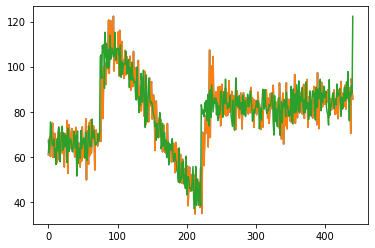

In [37]:
plt.plot(forecasts)
plt.plot(forecasts_tfds)
plt.plot(series_test[WINDOW_SIZE:])

In [46]:
PREDICTIONS[model_name] = model.predict(test_dataset)

## Evaluate

In [47]:
tf.keras.metrics.mean_squared_error(series_test[WINDOW_SIZE:], tf.squeeze(forecasts))

<tf.Tensor: shape=(), dtype=float32, numpy=89.02233>

In [48]:
tf.keras.metrics.mean_squared_error(series_test[WINDOW_SIZE:], tf.squeeze(forecasts_tfds))

<tf.Tensor: shape=(), dtype=float32, numpy=85.54544>

## Model 2: `dense-2layer`

In [49]:
model_name = 'dense-2layer'

In [50]:
model = tf.keras.models.Sequential([
    layers.Dense(10, input_shape=(WINDOW_SIZE, ), activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1)
], name=model_name)

lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
model.compile(loss='mse', optimizer=optimizers.SGD(learning_rate=1e-8, momentum=0.9))

model.summary()

Model: "dense-2layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [51]:
history = model.fit(train_dataset, epochs=100, callbacks=[lr_scheduler], verbose=0)
TFMODELS[model_name] = model

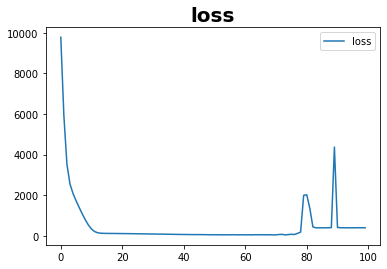

In [52]:
from tfutils.visualize import plot_learning_curve

plot_learning_curve(history);

In [53]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,lr
0,9779.232422,1.000000e-08
1,5920.751465,1.122018e-08
2,3520.989258,1.258925e-08
3,2547.612061,1.412538e-08
4,2076.897705,1.584893e-08


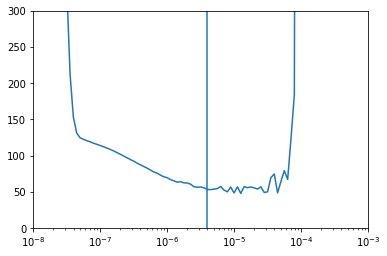

In [57]:
plt.semilogx(history_df['lr'], history_df['loss'])
plt.axis([1e-8, 1e-3, 0, 300]);
plt.axvline(4e-6);

In [58]:
model = tf.keras.models.clone_model(model)
model.compile(loss='mse', optimizer=optimizers.SGD(learning_rate=4e-6, momentum=0.9))
history = model.fit(train_dataset, epochs=500, verbose=0)
TFMODELS[model_name] = model

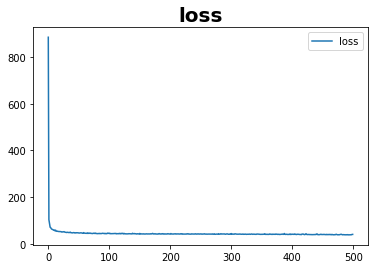

In [59]:
plot_learning_curve(history);

In [61]:
PREDICTIONS[model_name] = model.predict(test_dataset)

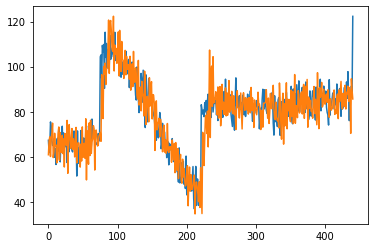

In [60]:
plt.plot(series_test[WINDOW_SIZE:], label='actual')
plt.plot(forecasts, label='forecasted')

In [63]:
tf.keras.metrics.mean_squared_error(series_test[WINDOW_SIZE:], tf.squeeze(PREDICTIONS[model_name]))

<tf.Tensor: shape=(), dtype=float32, numpy=44.767933>

The model with more Dense Layers has a lower mean squared error on the test set!

## Model 3: Stacked Bi-LSTM - 2layer

In [64]:
model_name = 'stacked-bilstm-2layer'

In [65]:
model = tf.keras.models.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=(None,)),
    layers.Bidirectional(layers.LSTM(units=32, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(units=32)),
    layers.Dense(1),
    layers.Lambda(lambda x: x*100)
], name=model_name)

lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizers.SGD(learning_rate=1e-8, momentum=0.9),
              metrics=['mse'])

model.summary()

Model: "stacked-bilstm-2layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [66]:
history = model.fit(train_dataset, epochs=100, callbacks=[lr_scheduler])

Epoch 1/100
31/31 [==============================] - 7s 8ms/step - loss: 32.3502 - mse: 1560.1129
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 26.0934 - mse: 996.5278
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 22.0776 - mse: 764.9430
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 21.8921 - mse: 757.0706
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 21.7352 - mse: 745.4830
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 21.5774 - mse: 734.6395
Epoch 7/100
31/31 [==============================] - 0s 8ms/step - loss: 21.3912 - mse: 723.4556
Epoch 8/100
31/31 [==============================] - 0s 8ms/step - loss: 21.2069 - mse: 710.5098
Epoch 9/100
31/31 [==============================] - 0s 9ms/step - loss: 20.9602 - mse: 696.4551
Epoch 10/100
31/31 [==============================] - 0s 8ms/step - loss: 20.7133 - mse: 678.2108
Epoch 11/100
31/31 [========

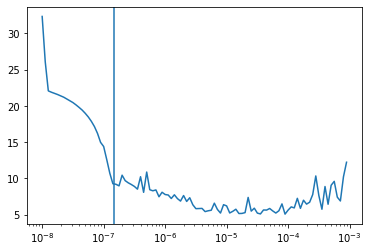

In [75]:
plt.semilogx(history.history['lr'], history.history['loss']);
plt.axvline(1.5e-7)

In [76]:
model = tf.keras.models.clone_model(model)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizers.SGD(learning_rate=1.5e-7, momentum=0.9),
              metrics=['mse'])

In [78]:
%%time

history = model.fit(train_dataset, epochs=500, verbose=0)
TFMODELS[model_name] =  model

CPU times: user 3min 33s, sys: 29.9 s, total: 4min 3s
Wall time: 2min 47s


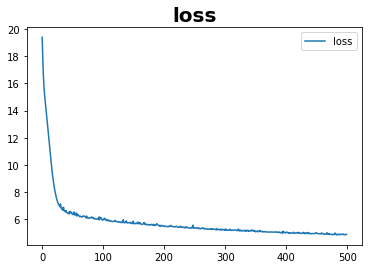

In [79]:
plot_learning_curve(model);

In [80]:
PREDICTIONS[model_name] = model.predict(test_dataset)

## Performance Comparison

In [82]:
scores = {model_name: tf.keras.metrics.mean_squared_error(x_test[WINDOW_SIZE:], tf.squeeze(pred)).numpy() for model_name, pred in PREDICTIONS.items()}
scores

{'dense-2layer': 44.767933,
 'simple-dense': 85.54544,
 'stacked-bilstm-2layer': 101.0342}

In [90]:
scores = dict(sorted(scores.items(), key=lambda x: x[1], reverse=False))
scores

{'dense-2layer': 44.767933,
 'simple-dense': 85.54544,
 'stacked-bilstm-2layer': 101.0342}

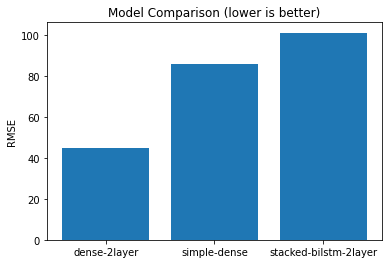

In [93]:
plt.bar(scores.keys(), scores.values())
plt.title('Model Comparison (lower is better)')
plt.ylabel('RMSE');